# Задача оценки индивиудальных эффектов от воздействия

## Загрузка данных

Мы будем работать с данным с соревнования "[MineThatData E-Mail Analytics And Data Mining Challenge](https://blog.minethatdata.com/2008/03/minethatdata-e-mail-analytics-and-data.html)", 2008 год.

Прежде всего нужно скачать данные.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Только для красоты, в реальной жизни Warnings могут помочь найти ошибку в коде
import warnings
warnings.filterwarnings('ignore')

In [3]:
db = pd.read_csv("http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv")

In [4]:
print(db.head())
print(db.info())
print(db.describe())

   recency history_segment  history  mens  womens   zip_code  newbie channel  \
0       10  2) $100 - $200   142.44     1       0  Surburban       0   Phone   
1        6  3) $200 - $350   329.08     1       1      Rural       1     Web   
2        7  2) $100 - $200   180.65     0       1  Surburban       1     Web   
3        9  5) $500 - $750   675.83     1       0      Rural       1     Web   
4        2    1) $0 - $100    45.34     1       0      Urban       0     Web   

         segment  visit  conversion  spend  
0  Womens E-Mail      0           0    0.0  
1      No E-Mail      0           0    0.0  
2  Womens E-Mail      0           0    0.0  
3    Mens E-Mail      0           0    0.0  
4  Womens E-Mail      0           0    0.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 12 columns):
recency            64000 non-null int64
history_segment    64000 non-null object
history            64000 non-null float64
mens             

In [5]:
db[['history_segment','zip_code','channel','segment']]= \
db[['history_segment','zip_code','channel','segment']].astype('category')

db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 12 columns):
recency            64000 non-null int64
history_segment    64000 non-null category
history            64000 non-null float64
mens               64000 non-null int64
womens             64000 non-null int64
zip_code           64000 non-null category
newbie             64000 non-null int64
channel            64000 non-null category
segment            64000 non-null category
visit              64000 non-null int64
conversion         64000 non-null int64
spend              64000 non-null float64
dtypes: category(4), float64(2), int64(6)
memory usage: 4.2 MB


Познакомтесь с выборкой данных. 

* Какая переменная отвечает за воздействие Trt?
* Сколько было воздействий?
* Какая(какие) переменный отвечают за переменную отклика Y?
* Какие есть независимые переменные X?

In [ ]:
# TODO

## Бизнес задача

Данные являются данными эксперимента, в котором людям рассылалось письмо с рекламой мужского или женского товара (случайно). Также треть людей не получала таких писем (контрольная группа).

В силу того, что подобное воздействие скорее приведёт человека в магазин и в меньшей степени увеличит его средний чек, переменной отклика являются бинарные переменные наличие визита, либо конверсии. В рамках данного семинара, будем рассматривать переменную визита в качестве переменной отклика.

Также будем рассматривать только контрольную группу и людей получивших рекламу женского товара в качестве тестовой группы

In [6]:
work_db=db.loc[(db.segment == "Womens E-Mail") | (db.segment == "No E-Mail")]
print(work_db.shape)
print(pd.value_counts(work_db.segment))

(42693, 12)
Womens E-Mail    21387
No E-Mail        21306
Mens E-Mail          0
Name: segment, dtype: int64


## Проверка качества модели

Предположим что у нас есть две модели, каждая из которых сделал своё предсказание. Как понять  какая модель лучше?

Сначала предсказания:

In [7]:
deltaVisit1 = pd.Series(np.random.random_sample(work_db.shape[0]) * 2 - 1)
deltaVisit2 = pd.Series(np.random.random_sample(work_db.shape[0]) * 2 - 1)

В данном случае будем считать, что мы можем отправить только 10000 сообщений. Нам необходимо понять, кому из 40000 клиентов мы будем отправлять сообщения.

Для этого воспользуемся каждой моделью и отберём лучшие с точки зрения модели предсказания:

In [8]:
model1_top_10percent_quality = deltaVisit1.sort_values(ascending=False)[10000]
model2_top_10percent_quality = deltaVisit2.sort_values(ascending=False)[10000]


Для оценки качества предсказаний нам потребуется только та часть данных, которая касается Y и Trt

In [9]:
yTrtDB = work_db[["segment","visit"]]

Выберем только лучшие с точки зрения каждой модели наблюдения.

In [10]:
model1_db = yTrtDB.loc[deltaVisit1.values >= model1_top_10percent_quality]
model2_db = yTrtDB.loc[deltaVisit2.values >= model2_top_10percent_quality]

Теперь нужно определиться как мерить качество. В маркетинге обычно интересует общий эффект, от воздействия. Действительно, даже если мы увеличиваем вероятность прихода на 0.001%, а воздействие бесплатное, то это потенциально может принести деньги в компанию. Поэтому зададим функцию качества как общий эффект от воздействия.

In [11]:
def TotalTreatmentEffect(y,trt):
    return (y[trt == 1].mean() - y[trt==0].mean() )*len(y)

In [12]:
y=model1_db.visit
trt=model1_db.segment=="Womens E-Mail"

print(y[trt==1].mean())
print(y[trt==0].mean())
print(len(y))

print( TotalTreatmentEffect(y,trt))

0.15552069033143753
0.10956521739130434
10274
472.1465289869284


Вторая модель:

In [13]:
print( TotalTreatmentEffect(model2_db.visit,model2_db.segment=="Womens E-Mail"))

967.5086661801993


А если сразу всем людям отправлять сообщение?

In [14]:
print( TotalTreatmentEffect(yTrtDB.visit,yTrtDB.segment=="Womens E-Mail"))

1931.1370195210532


Вариативность предсказания очень большая. Чтобы её оценить нужна cross-валидация. Об этом позже.

## Метод двух моделей

Метод двух моделей заключается в разделении обучающей выборки на две части в соответсвии с переменной Trt. В этом случае будут обучены две модели. Разница предсказаний этих моделей и есть предсказание эффекта от воздействия. Сами модели могут строится любым алгоритмом машинного обучения.

Для начала нужно определить функцию, которая будет обучать модель.

In [15]:
def TrainTwoModels(X, y, trt, getModelFunc):
    m1 = None # TODO
    m0 = None # TODO
    return {'M1': m1, 'M0': m0}

И теперь обучаем модель. Для этого сначала создаем функцию, которая возвращает объект логистической регрессии

In [16]:
from sklearn.linear_model import LogisticRegression

def getLogisticRegressionModel():
 return LogisticRegression(random_state=0,solver="lbfgs")


In [17]:
twoLogisticModels = TrainTwoModels(\
    pd.get_dummies(work_db.drop(columns=["segment","visit","conversion","spend"])), \
    work_db.visit, work_db.segment=="Womens E-Mail",getLogisticRegressionModel)

Теперь определим функцию предсказания с помощью двух моделей

In [18]:
def PredictByTwoModels(model, X):
    return None # TODO

И само предсказание

In [19]:
deltaYTwoModels = PredictByTwoModels(twoLogisticModels, pd.get_dummies(work_db.drop(columns=["segment","visit","conversion","spend"])))
np.percentile(deltaYTwoModels,q=[0,0.25,0.5,0.75,1])

array([-0.08319907, -0.05222644, -0.0438424 , -0.03691383, -0.03145958])

## Сведение к задаче классификации

В данном подразделе мы изменим переменную Y так, чтобы можно было решать обычную задачу классификации.

Определим специальную функцию обучения:

In [20]:
def TrainTaskReduction(X,y,trt,getModelFunc):
    z = None # TODO
    weights = None # TODO
    return getModelFunc().fit(X, z, sample_weight=weights)

Обучаем логистическую регрессию

In [21]:
taskReductionModel = TrainTaskReduction(\
    pd.get_dummies(work_db.drop(columns=["segment","visit","conversion","spend"])), \
    work_db.visit, work_db.segment=="Womens E-Mail",getLogisticRegressionModel)

Предсказание в этом случае делается через стандартную функцию с обратным преобразованием в вероятность. Обратите внимание, что предсказания распределены похожим образом на метод двух моделей.

In [22]:
def PredictTaskReduction(model,X):
    return None # TODO

In [23]:
deltaYTaskReduction = PredictTaskReduction(taskReductionModel,\
    pd.get_dummies(work_db.drop(columns=["segment","visit","conversion","spend"])))
np.percentile(deltaYTaskReduction,q=[0,0.25,0.5,0.75,1])

array([-0.04235853, -0.03775481, -0.03375118, -0.03090379, -0.02898568])

## Сравнение моделей

В данном раздели мы сравним какая из описанных выше моделей более надёжна на этих данных. Сама задача оценки эффекта от воздействия намного более склонна к переобучению, чем классические задачи классификации и регресси.

Поэтому многократная cross-валидация крайне желательна. Вариант k-fold cross-валидация здесь не применима. Поэтому будем многократно бить случайно на обучающую и тестовую выборки, обучать модели и сравнивать качество.

Напомним, что качество мы будем считать как максимальный общий эффект от воздействия достигнутый на выборке размера 10000.

In [24]:
def TotalTreatmentEffect(y,trt):
    return (y[trt == 1].mean() - y[trt==0].mean() )*len(y)

Ниже определены параметры, которые будут использоваться в нашей cross-валидации.

In [25]:
cv_Num=20 # Количество итераций (случайных сплитов на train-test)
cv_prop = 0.5 # Пропорция всех наблюдений, попадающих в обучающую выборку
cv_n_select = 5000 # Скольким клиентам можем отправить СМС из тестовой выборке

# Это для удобства доступа к независимым переменным, переменной отклика и переменной воздействия.
X_all = pd.get_dummies(work_db.drop(columns=["segment","visit","conversion","spend"]))
Y_all = work_db.visit
Trt_all = work_db.segment=="Womens E-Mail"

# И общее количество наблюдений
n = X_all.shape[0]

In [26]:
# В таблице result должны быть две колонки и cv_Num строк.
# Каждая колонка соответсвует одному из тестируемых методов.
# Каждая строка соответсвует одной итерации разбиения выборки данных на train-test
result = pd.DataFrame(None, columns=["Q_2m","Q_Reduct"])

# Напишите функцию cross-валидации, которая заполняет таблицу result
# TODO

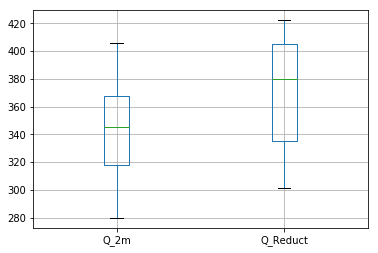

In [28]:
result.boxplot()